In [140]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

import numpy as np
import matplotlib.pyplot as plt

In [141]:
INPUT_SIZE = 784
NUM_LAYERS = 3
NUM_CLASSES = 10
NUM_EPOCHS = 50
BATCH_SIZE = 10
LEARNING_RATE = 0.1

NUM_SAMPLES = 2000
NUM_TRAIN_SAMPLES = 100

In [142]:
# MNIST dataset 
dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)

sample_index=list(range(NUM_SAMPLES))
train_index=list(np.random.choice(range(NUM_SAMPLES),size=NUM_TRAIN_SAMPLES,replace=False))

sample_dataset=Subset(dataset, sample_index)
train_dataset=Subset(sample_dataset, train_index)

# Data loader
TRAIN_LOADER = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

SAMPLE_LOADER = DataLoader(dataset=sample_dataset,batch_size=1,shuffle=False)

In [143]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size)
        for k in range(num_layers-1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [144]:
def get_bounds(sample_loader, train_loader, num_samples, num_train, delta, hidden_size, num_layers, alphas):
    model = NeuralNet(INPUT_SIZE,hidden_size, num_layers, NUM_CLASSES)
    ReLU_glorot_init(model)
            
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(NUM_EPOCHS):
        for images, labels in train_loader:
            images = images.reshape(-1, INPUT_SIZE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    train_error=0
    with torch.no_grad():
        for image, label in train_loader:
            image = image.reshape(-1, INPUT_SIZE)
            output = model(image)
            loss = criterion(output, label)
            train_error+=loss.item()*len(image)
    train_error=train_error/num_train

    true_error=0
    classifications=[]
    C=0
    with torch.no_grad():
        for image, label in sample_loader:
            image = image.reshape(-1, INPUT_SIZE)
            output = model(image)
            loss = criterion(output, label)
            if C<loss.item():
                C=loss.item()
            true_error+=loss.item()
            predictions=output.max(1)[1]
            classifications+=(predictions==label).tolist()
    p_Delta=sum(classifications)/num_samples
    true_error=true_error/num_samples
    bound_point=train_error+C*np.sqrt(np.log(1/delta)/(2*int(num_train)))
    bound_point_higher_sample=[]
    for alpha in alphas:
        bound_point_higher_sample.append(train_error+C*np.sqrt(np.log(1/delta)/(2*int(num_train*alpha))))

    log_component = np.log((1-p_Delta+np.sqrt((1-p_Delta)**2+4*delta**(1/num_train)*p_Delta))/(2*delta**(1/num_train)))

    bound_region=train_error+np.sqrt(C**2*log_component/2)
    
    return train_error, true_error, bound_region, bound_point, bound_point_higher_sample, p_Delta

In [145]:
LAYER_SIZES=[1,2,3,4]
HIDDEN_SIZES=[4,8,16,32,128,256]
ALPHAS=[1.25,1.5,2.5]
NUM_TESTS=20

true_errors=[]
bounds_region=[]
bounds_point=[]
bounds_point_hs1=[]
bounds_point_hs2=[]
bounds_point_hs3=[]
p_Deltas=[]
for num_layers in LAYER_SIZES:
    for h_size in HIDDEN_SIZES:
        for n in range(NUM_TESTS):
            tr_er, ts_er, b_r, b_p, b_p_hs, p = get_bounds(SAMPLE_LOADER, TRAIN_LOADER, NUM_SAMPLES, NUM_TRAIN_SAMPLES, 0.05, h_size, num_layers, ALPHAS)
            true_errors.append(ts_er)
            bounds_region.append(b_r)
            bounds_point.append(b_p)
            bounds_point_hs1.append(b_p_hs[0])
            bounds_point_hs2.append(b_p_hs[1])
            bounds_point_hs3.append(b_p_hs[2])
            p_Deltas.append(p)
            print('Number of Layers {} Hidden Size {} Test number {}'.format(num_layers,h_size,n+1))

Number of Layers 1 Hidden Size 4 Test number 1
Number of Layers 1 Hidden Size 4 Test number 2
Number of Layers 1 Hidden Size 4 Test number 3
Number of Layers 1 Hidden Size 4 Test number 4
Number of Layers 1 Hidden Size 4 Test number 5
Number of Layers 1 Hidden Size 4 Test number 6
Number of Layers 1 Hidden Size 4 Test number 7
Number of Layers 1 Hidden Size 4 Test number 8
Number of Layers 1 Hidden Size 4 Test number 9
Number of Layers 1 Hidden Size 4 Test number 10
Number of Layers 1 Hidden Size 4 Test number 11
Number of Layers 1 Hidden Size 4 Test number 12
Number of Layers 1 Hidden Size 4 Test number 13
Number of Layers 1 Hidden Size 4 Test number 14
Number of Layers 1 Hidden Size 4 Test number 15
Number of Layers 1 Hidden Size 4 Test number 16
Number of Layers 1 Hidden Size 4 Test number 17
Number of Layers 1 Hidden Size 4 Test number 18
Number of Layers 1 Hidden Size 4 Test number 19
Number of Layers 1 Hidden Size 4 Test number 20
Number of Layers 1 Hidden Size 8 Test number 1
Nu

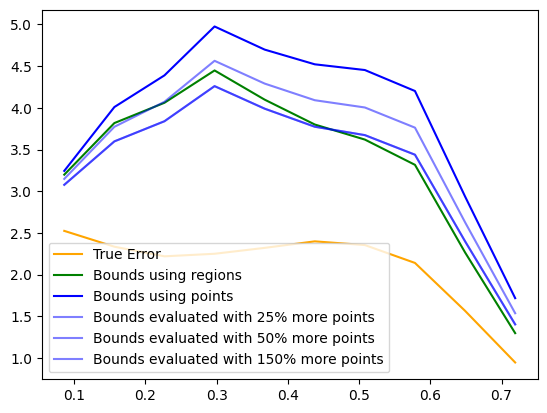

In [146]:
NUM_BINS=10
min_p=min(p_Deltas)
max_p=max(p_Deltas)
range_p=max_p-min_p
bin_size=range_p/NUM_BINS
p_Deltas_bins=np.linspace(min_p,max_p,NUM_BINS+1)
true_errors_partitioned=[[] for n in range(NUM_BINS)]
bounds_region_partitioned=[[] for n in range(NUM_BINS)]
bounds_point_partitioned=[[] for n in range(NUM_BINS)]
bounds_point_partitioned_hs1=[[] for n in range(NUM_BINS)]
bounds_point_partitioned_hs2=[[] for n in range(NUM_BINS)]
bounds_point_partitioned_hs3=[[] for n in range(NUM_BINS)]
for n in range(len(p_Deltas)):
    bin_ind=int((p_Deltas[n]-min_p)/bin_size)
    if bin_ind==NUM_BINS:
        bin_ind=-1
    true_errors_partitioned[bin_ind].append(true_errors[n])
    bounds_region_partitioned[bin_ind].append(bounds_region[n])
    bounds_point_partitioned[bin_ind].append(bounds_point[n])
    bounds_point_partitioned_hs1[bin_ind].append(bounds_point_hs1[n])
    bounds_point_partitioned_hs2[bin_ind].append(bounds_point_hs2[n])
    bounds_point_partitioned_hs3[bin_ind].append(bounds_point_hs3[n])
true_error_bin_avg=[]
bounds_region_bin_avg=[]
bounds_point_bin_avg=[]
bounds_point_bin_avg_hs1=[]
bounds_point_bin_avg_hs2=[]
bounds_point_bin_avg_hs3=[]
for n in range(len(true_errors_partitioned)):
    ts_er_bin=true_errors_partitioned[n]
    bs_r_bin=bounds_region_partitioned[n]
    bs_p_bin=bounds_point_partitioned[n]
    bs_p_bin_hs1=bounds_point_partitioned_hs1[n]
    bs_p_bin_hs2=bounds_point_partitioned_hs2[n]
    bs_p_bin_hs3=bounds_point_partitioned_hs3[n]
    if len(ts_er_bin)==0 and n!=0:
        true_error_bin_avg.append(true_error_bin_avg[n-1])
    else:
        true_error_bin_avg.append(sum(ts_er_bin)/len(ts_er_bin))
    if len(bs_r_bin)==0 and n!=0:
        bounds_region_bin_avg.append(bounds_region_bin_avg[n-1])
    else:
        bounds_region_bin_avg.append(sum(bs_r_bin)/len(bs_r_bin))
    if len(bs_p_bin)==0 and n!=0:
        bounds_point_bin_avg.append(bounds_point_bin_avg[n-1])
    else:
        bounds_point_bin_avg.append(sum(bs_p_bin)/len(bs_p_bin))
    if len(bs_p_bin_hs1)==0 and n!=0:
        bounds_point_bin_avg_hs1.append(bounds_point_bin_avg_hs1[n-1])
    else:
        bounds_point_bin_avg_hs1.append(sum(bs_p_bin_hs1)/len(bs_p_bin_hs1))
    if len(bs_p_bin_hs2)==0 and n!=0:
        bounds_point_bin_avg_hs2.append(bounds_point_bin_avg_hs2[n-1])
    else:
        bounds_point_bin_avg_hs2.append(sum(bs_p_bin_hs2)/len(bs_p_bin_hs2))
    if len(bs_p_bin_hs3)==0 and n!=0:
        bounds_point_bin_avg_hs3.append(bounds_point_bin_avg_hs3[n-1])
    else:
        bounds_point_bin_avg_hs3.append(sum(bs_p_bin_hs3)/len(bs_p_bin_hs3))
plt.plot(p_Deltas_bins[:-1],true_error_bin_avg,c='orange',label='True Error')
plt.plot(p_Deltas_bins[:-1],bounds_region_bin_avg,c='green',label='Bounds using regions')
plt.plot(p_Deltas_bins[:-1],bounds_point_bin_avg,c='blue',label='Bounds using points')
plt.plot(p_Deltas_bins[:-1],bounds_point_bin_avg_hs1,c='blue',alpha=0.5,label='Bounds evaluated with 25% more points')
plt.plot(p_Deltas_bins[:-1],bounds_point_bin_avg_hs2,c='blue',alpha=0.5,label='Bounds evaluated with 50% more points')
plt.plot(p_Deltas_bins[:-1],bounds_point_bin_avg_hs2,c='blue',alpha=0.5,label='Bounds evaluated with 150% more points')
plt.legend()
plt.savefig('plots/Region_against_Point_Bounds_line.png')

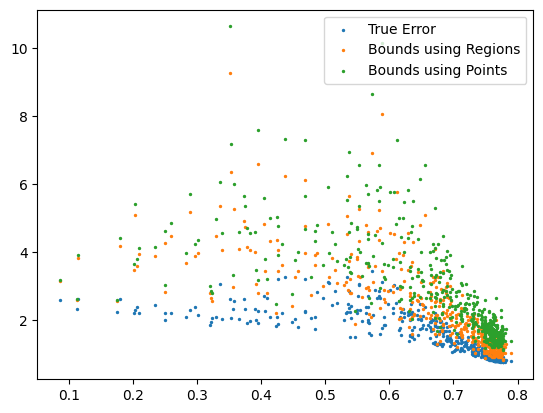

In [147]:
plt.scatter(p_Deltas,true_errors,s=2,label='True Error')
plt.scatter(p_Deltas,bounds_region,s=2,label='Bounds using Regions')
plt.scatter(p_Deltas,bounds_point,s=2,label='Bounds using Points')
plt.legend()
plt.savefig('plots/Region_against_Point_Bounds_scatter.png')